In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.optimize as opt
import scipy.stats as rnd
from scipy.optimize import minimize
import time
from datetime import datetime as dtm
from datetime import date as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import seaborn as sns

C:\Apps\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from WindPy import *
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [20]:
basic = w.wss("10001989.SH,10001990.SH,10001991.SH,10001992.SH,10001993.SH,10001994.SH,10001995.SH,10001996.SH,10001997.SH,10001998.SH,10001999.SH,10002000.SH,10002001.SH,10002002.SH,10002003.SH,10002004.SH,10002005.SH,10002006.SH,10002007.SH,10002008.SH,10002009.SH,10002010.SH,10002083.SH,10002084.SH,10002085.SH,10002086.SH,10002087.SH,10002088.SH,10002089.SH,10002090.SH,10002091.SH,10002092.SH,10002093.SH,10002094.SH,10002095.SH,10002096.SH,10002097.SH,10002098.SH,10002099.SH,10002100.SH,10002107.SH,10002108.SH,10002115.SH,10002116.SH,10002213.SH,10002214.SH,10002231.SH,10002232.SH,10002233.SH,10002234.SH,10002235.SH,10002236.SH,10002237.SH,10002238.SH,10002239.SH,10002240.SH,10002241.SH,10002242.SH,10002243.SH,10002244.SH,10002245.SH,10002246.SH,10002247.SH,10002248.SH,10002269.SH,10002270.SH,10002291.SH,10002292.SH,10002293.SH,10002294.SH,10002295.SH,10002296.SH,10002297.SH,10002298.SH,10002299.SH,10002300.SH,10002301.SH,10002302.SH,10002303.SH,10002304.SH,10002305.SH,10002306.SH,10002307.SH,10002308.SH,10002401.SH,10002402.SH,10002403.SH,10002404.SH,10002405.SH,10002406.SH,10002407.SH,10002408.SH,10002421.SH,10002422.SH,10002423.SH,10002424.SH,10002433.SH,10002434.SH,10002435.SH,10002436.SH,10002437.SH,10002438.SH,10002439.SH,10002440.SH,10002441.SH,10002442.SH,10002443.SH,10002444.SH,10002445.SH,10002446.SH,10002447.SH,10002448.SH,10002449.SH,10002450.SH,10002469.SH,10002470.SH,10002471.SH,10002472.SH,10002475.SH,10002476.SH,10002477.SH,10002478.SH,10002479.SH,10002480.SH,10002481.SH,10002482.SH,10002483.SH,10002484.SH,10002485.SH,10002486.SH,10002487.SH,10002488.SH,10002489.SH,10002490.SH,10002491.SH,10002492.SH,10002493.SH,10002494.SH,10002513.SH,10002514.SH", "exe_price,underlyingwindcode,exe_enddate,exe_type,exe_mode","tradeDate=20200422",usedf=True)[1]

In [24]:
basic.to_pickle("basic.pkl")

In [3]:
basic = pd.read_pickle("basic.pkl")

In [4]:
und = w.wsi("510050.SH", "close", "2020-04-24 09:00:00", "2020-04-24 15:00:00", "BarSize=60",usedf=True)[1]["close"]

In [5]:
r = w.wss("TB1Y.WI", "close","tradeDate=20200424;priceAdj=U;cycle=D").Data[0][0]/100

In [7]:
opt_close = []
for code in basic.index:
    ret = w.wsi(code, "close", "2020-04-24 09:30:00", "2020-04-24 15:00:00", "BarSize=60",usedf=True)[1]
    opt_close.append(ret)

In [8]:
data = pd.concat({c:x["close"] for c,x in zip(basic.index,opt_close) if "close" in x},axis=1)

In [26]:
call_code = pd.pivot_table(basic[basic["EXE_MODE"]=="认购"].reset_index(),index="EXE_ENDDATE",columns="EXE_PRICE",values="code",aggfunc="sum")

In [27]:
put_code = pd.pivot_table(basic[basic["EXE_MODE"]=="认沽"].reset_index(),index="EXE_ENDDATE",columns="EXE_PRICE",values="code",aggfunc="sum")

In [28]:
def find_val(x):
    if x is np.nan or x not in data.iloc[0]:
        return np.nan
    return data.iloc[0][x]

In [29]:
call_close = call_code.applymap(find_val)
put_close = put_code.applymap(find_val)

In [32]:
call_close.to_pickle("call_close.pkl")
put_close.to_pickle("put_close.pkl")

In [7]:
call_close = pd.read_pickle("call_close.pkl")
put_close = pd.read_pickle("put_close.pkl")

### calc q

In [8]:
S=und[0]

In [9]:
atmx = (call_close - put_close).abs().idxmin(axis=1)

In [10]:
tau = pd.Series((atmx.index-dtm(2020,4,24)).days,index=atmx.index)/365

In [11]:
spread = (call_close-put_close)
spread = pd.Series([spread.loc[row,col] for row,col in atmx.iteritems()], index=spread.index)

In [12]:
q = r-np.log((spread*np.exp(r*tau)+atmx)/S)/tau

### calc iv

In [13]:
def bsm(iv,s,x,t,r,q,call=True):
    d1 = (np.log(s/x) + (r-q+iv**2/2)*t)/(iv*np.sqrt(t))
    d2 = d1 - iv*np.sqrt(t)
    if call:
        return s*np.exp(-q*t)*sp.stats.norm.cdf(d1)-x*np.exp(-r*t)*sp.stats.norm.cdf(d2)
    else:
        return x*np.exp(-r*t)*sp.stats.norm.cdf(-d2)-s*np.exp(-q*t)*sp.stats.norm.cdf(-d1)
def mae(iv,s,x,t,r,q,tar,call):
    bsmv = bsm(iv,s,x,t,r,q,call)
    return np.abs(bsmv-tar)

In [14]:
def calc_iv(data,S,tau,r,q,call=True):
    IV = np.full(data.shape,np.nan)
    for row,idx in enumerate(data.index):
        for col,strike in enumerate(data.columns):
            if pd.isna(data.loc[idx,strike]):continue            
            tar = data.loc[idx,strike]
            IV[row,col] = opt.minimize_scalar(mae,bounds=(0.01,0.99),args=(S,strike,tau[row],r,q[row],tar,call)).x
    return pd.DataFrame(IV,index=data.index,columns=data.columns)


In [15]:
call_iv = calc_iv(call_close,S,tau,r,q,True)
put_iv = calc_iv(put_close,S,tau,r,q,False)

C:\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [16]:
iv_surf = pd.concat([put_iv.iloc[:,put_iv.columns<S],call_iv.iloc[:,call_iv.columns>S]],axis=1)

In [45]:
term = 1
totalv = np.square(iv_surf)*tau.values[(slice(None),None)]

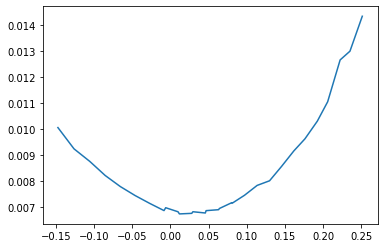

In [19]:
totalv.iloc[term].dropna().plot.line()

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from svi import svi_2steps,svi_raw,quasi2raw,svi_quasi,svi_quasi_model,plot_tv,plot_iv

In [58]:
res = []
for i in range(len(totalv)):
    ava_data = totalv.iloc[i].dropna()
    logm = np.log(ava_data.index.values/(S*np.exp((r-q[i])*tau[i])))
    a,d,c,m,sigma,rmse = svi_2steps(ava_data.values,logm,[0.05,0.1],10)
    res.append((logm,ava_data,(a,d,c,m,sigma),rmse))

round 1: RMSE=3.671917685604511e-05 para=[0.0015786411569403145, -0.0013037614746581072, 0.0020723873859134134, -0.04858835669164961, 0.09626404066305336]     
round 2: RMSE=3.671917685604511e-05 para=[0.0015786411569403145, -0.0013037614746581072, 0.0020723873859134134, -0.04858835669164961, 0.09626404066305336]     

finished. params = [ 0.00157864 -0.00130376  0.00207239 -0.04858836  0.09626404]
round 1: RMSE=0.0001847249110164403 para=[2.3109624561568033e-10, 0.003345569879408735, 0.007543781306707761, 0.11131204260937051, 0.1391667411678374]     
round 2: RMSE=0.00018472491101644014 para=[2.3109564613806455e-10, 0.0033455698908467697, 0.007543781314780404, 0.11131204285107184, 0.13916674133747067]     

finished. params = [2.00000000e-10 3.34556990e-03 7.54378130e-03 1.11312043e-01
 1.39166741e-01]
round 1: RMSE=0.00011682357469180015 para=[1.6363504665965388e-07, 0.002050184123600008, 0.01871143883211552, 0.0659121525846234, 0.2777872340813673]     
round 2: RMSE=0.00011682357469

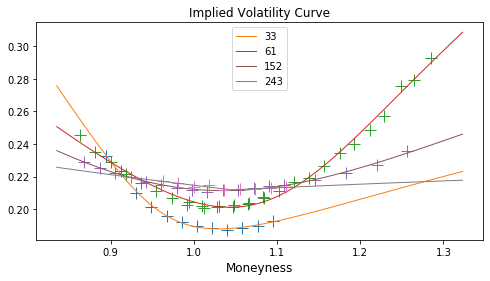

In [119]:
lmax,lmin = 0.28,-0.18
lin = np.linspace(lmin,lmax,100)
plt.figure(figsize=( 8,4))
for i in range(len(res)):
    model = svi_quasi_model(*res[i][2])
    t=tau[i]
    logm=res[i][0]
    tv = res[i][1]    
    plt.plot(np.exp(logm), np.sqrt(tv/t), '+', markersize=12)
    plt.plot(np.exp(lin),np.sqrt(model(lin)/t),linewidth=1,label=str(int(tau[i]*365)))
plt.title("Implied Volatility Curve")
plt.xlabel("Moneyness", fontsize=12)
plt.legend()
plt.show()

In [94]:
def raw_svi(par, k):
    w = par[0] + par[1] * (par[2] * (k - par[3]) + (
                (k - par[3]) ** 2 + par[4] ** 2) ** 0.5)
    return w
def diff_svi(par, k):
    a, b, rho, m, sigma = par
    return b*(rho+(k-m)/(np.sqrt((k-m)**2+sigma**2)))
def diff2_svi(par, k):
    a, b, rho, m, sigma = par
    disc = (k-m)**2 + sigma**2
    return (b*sigma**2)/((disc)**(3/2))
def gfun(par, k):
    w = raw_svi(par, k)
    w1 = diff_svi(par, k)
    w2 = diff2_svi(par, k)
    g = (1-0.5*(k*w1/w))**2 - (0.25*w1**2)*(w**-1+0.25) + 0.5*w2
    return g
def d2(par, k):
    v = np.sqrt(raw_svi(par, k))
    return -k/v - 0.5*v
def density(par, k):
    g = gfun(par, k)
    w = raw_svi(par, k)
    dtwo = d2(par, k)
    dens = (g / np.sqrt(2 * np.pi * w)) * np.exp(-0.5 * dtwo**2)
    return dens

In [106]:
def g(par,k):
    a,b,rho,m,sig = par
    discr = np.sqrt((k-m)*(k-m) + sig*sig);
    w = a + b *(rho*(k-m)+ discr);
    dw = b*rho + b *(k-m)/discr;
    d2w = b*sig**2/(discr*discr*discr);
    
    return 1 - k*dw/w + dw*dw/4*(-1/w+k*k/(w*w)-4) +d2w/2

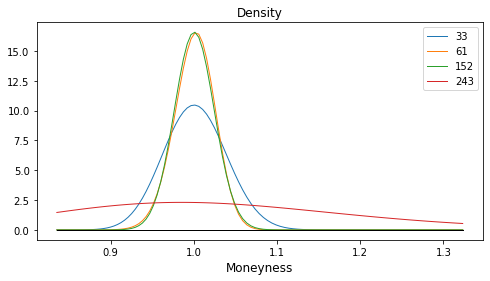

In [120]:
lmax,lmin = 0.28,-0.18
lin = np.linspace(lmin,lmax,100)
plt.figure(figsize=(8,4))
for i in range(len(res)):
    t=tau[i]
    logm=res[i][0]
    tv = res[i][1]    
    plt.plot(np.exp(lin),density(res[i][2],lin),linewidth=1,label=str(int(tau[i]*365)))
plt.plot(np.exp(lin),np.zeros(100),linewidth=1,color="black")
plt.title("Density")
plt.xlabel("Moneyness", fontsize=12)
plt.legend()
plt.show()

In [ ]:
lmax,lmin = 0.28,-0.18
lin = np.linspace(lmin,lmax,100)
plt.figure(figsize=(8,4))
for i in range(len(res)):
    t=tau[i]
    logm=res[i][0]
    tv = res[i][1]    
    plt.plot(np.exp(lin),density(res[i][2],lin),linewidth=1,label=str(int(tau[i]*365)))

In [124]:
surf = np.zeros((4,25))
lin = np.linspace(0.9,1.15,25)
for i in range(4):
    model = svi_quasi_model(*res[i][2])
    surf[i,:] = model(np.log(lin))

In [152]:
final_surf = np.zeros((16,25))
tt = np.linspace(33,243,16)
for j in range(25):
    final_surf[:,j] = sp.interpolate.interp1d(tau*365,surf[:,j])(tt)

In [159]:
from mpl_toolkits.mplot3d import Axes3D

In [186]:
final_surf.shape

(16, 25)

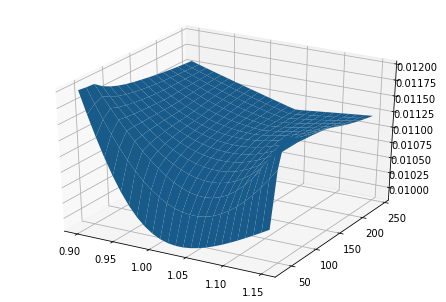

In [191]:
fig = plt.figure() 
axes3d = Axes3D(fig) 
ttt = tt/365
M,T = np.meshgrid(lin,tt)
axes3d.plot_surface(M,T,np.sqrt(final_surf/tt[slice(None),None]),rstride=1,cstride=1)
plt.show()

In [175]:
final_surf.shape

(16, 25)

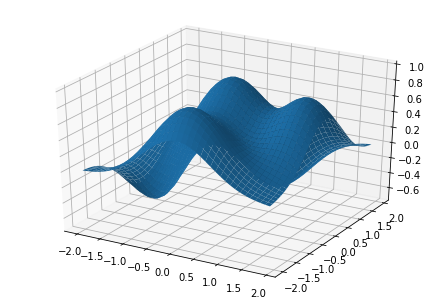

In [170]:
fig = plt.figure()
'''创建3D轴对象'''
ax = Axes3D(fig)
'''X坐标数据'''
X = np.arange(-2,2,0.1)
'''Y坐标数据'''
Y = np.arange(-2,2,0.1)
'''计算3维曲面分格线坐标'''
X,Y = np.meshgrid(X,Y)
'''用于计算X/Y对应的Z值'''
def f(x,y):
    return (1-y**5+x**5)*np.exp(-x**2-y**2)
'''plot_surface函数可绘制对应的曲面'''
ax.plot_surface(X,Y,f(X,Y),rstride=1,cstride=1)